## **1. Import Libraries**
This section imports essential libraries for data manipulation, visualization, preprocessing, and machine learning. Libraries like `pandas`, `matplotlib`, and `scikit-learn` are used extensively for data analysis and model training.

In [1]:
# Import Libraries

# Standard libraries
import numpy as np  # Numerical computations
import os  # Operating system interactions (e.g., environment variables)

# Data manipulation and visualization
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization

## **2. Define Helper Functions**
The `FolderToDictData` function read text data from a specified folder and organize them into dictionaries for further processing.


In [2]:
from PIL import Image
def FolderToDictData(folder_path):
    """
    Reads files in a folder, extracts numerical data, and organizes it into a dictionary.
    
    Args:
        folder_path (str): Path to the folder containing the files.

    Returns:
        tuple: (data_dict, file_names)
            - data_dict: A dictionary where keys are file names (without extension) and values are numpy arrays of file data.
            - file_names: A list of file names (without extensions).
    """
    # Initialize lists for file paths and names
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    file_names = [os.path.splitext(f)[0] for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Read file contents
    files_contents = [open(fp, 'r').read() for fp in file_paths]

    # Initialize parameters
    nb_of_features = 7
    data_dict = {}

    # Process each file's content
    for file_name, file_content in zip(file_names, files_contents):
        # Split file content into samples and initialize data array
        samples = file_content.strip().split('\n')
        data = np.zeros((len(samples), nb_of_features))

        # Parse each sample into numerical data
        for i, sample in enumerate(samples):
            d = sample.split(' ')
            if len(d) == nb_of_features + 1:  # Verify data format
                data[i, :] = d[:nb_of_features]  # Extract relevant features

        # Store processed data in dictionary (remove trailing empty rows)
        data_dict[file_name] = data[1:-1,:]

    return data_dict, file_names


## **3. Load and Preprocess Data**
Here, the patient data and target labels (`Y`) are loaded and processed.


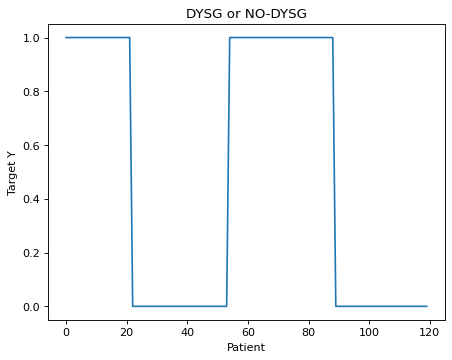

In [3]:
# Load text data
folder_path = '../data/raw/txt_data'
data_dict, user_names = FolderToDictData(folder_path)

# Load and preprocess target labels
df = pd.read_excel('../data/raw/labels.xlsx')
dataY = (df['diag'] != 0).astype(int).values

# Plot target distribution
plt.figure(dpi=80)
plt.plot(dataY)
plt.xlabel('Patient')
plt.ylabel('Target Y')
plt.title('DYSG or NO-DYSG')
plt.show()


## **4. Visualize Patient Data**
This section generates visualizations for features such as X-Y positions, pressure, azimuth, and altitude for a specific patient.


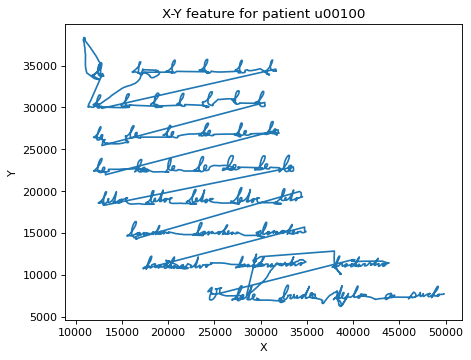

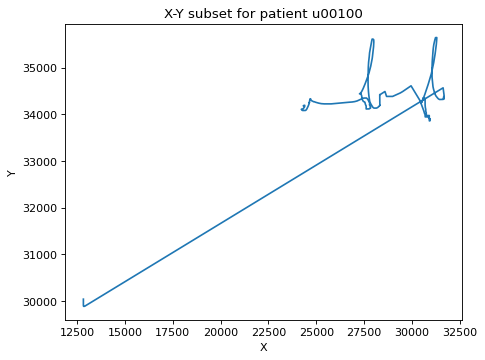

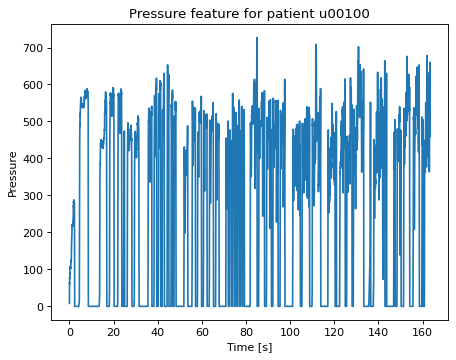

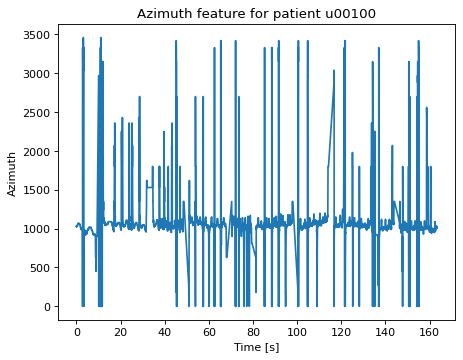

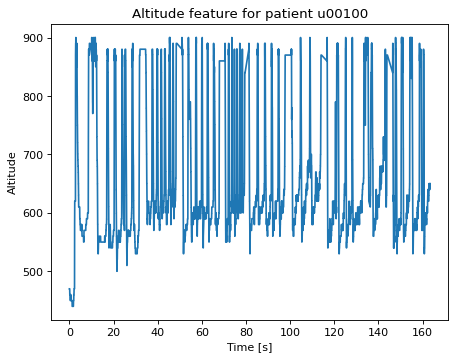

In [4]:
# Visualize X-Y positions for a specific patient
patient_name = 'u00100'
position_x, position_y = data_dict[patient_name][:, 0], data_dict[patient_name][:, 1]

plt.figure(dpi=80)
plt.plot(position_x, position_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y feature for patient {patient_name}')
plt.show()

# Visualize a subset of X-Y positions
plt.figure(dpi=80)
plt.plot(position_x[3000:4100], position_y[3000:4100])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y subset for patient {patient_name}')
plt.show()

# Plot other features (pressure, azimuth, altitude)
time = data_dict[patient_name][:, 2] - data_dict[patient_name][0, 2]

features = {'Pressure': 6, 'Azimuth': 4, 'Altitude': 5}
for feature_name, col in features.items():
    plt.figure(dpi=80)
    plt.plot(time * 1e-3, data_dict[patient_name][:, col])
    plt.xlabel('Time [s]')
    plt.ylabel(feature_name)
    plt.title(f'{feature_name} feature for patient {patient_name}')
    plt.show()


## **Save and Download X-Y Plots**

### Compute Speed and Store in a Dictionary
This cell calculates the speed along the x and y axes (speed_x, speed_y) and the total speed (speed) for each user based on position data. The results are stored in a dictionary for later use. The process includes:

1. Extracting time, x, and y position data.
2. Iteratively calculating velocities using the difference in position and time.
3. Clipping speeds to a predefined range (0 to 10).
4. Storing computed speeds in the speed_dict.

In [5]:
# Compute speeds (x, y, and total) for all users
speed_dict = {}
for user_name in user_names:
    time = data_dict[user_name][:, 2] - data_dict[user_name][0, 2]  # Relative time (ms)
    position_x, position_y = data_dict[user_name][:, 0], data_dict[user_name][:, 1]
    speed_x, speed_y, speed = [0], [0], [0]  # Initialize speeds with zero

    for i in range(1, len(position_x)):
        delta_t = max((time[i] - time[i - 1]) * 1e-3, 1e-6)  # Ensure no division by zero
        vx = np.clip((position_x[i] - position_x[i - 1]) * 1e-3 / delta_t, 0.0, 10.0)
        vy = np.clip((position_y[i] - position_y[i - 1]) * 1e-3 / delta_t, 0.0, 10.0)
        speed_x.append(vx)
        speed_y.append(vy)
        speed.append((vx**2 + vy**2)**0.5)  # Total speed

    speed_dict[user_name] = {"speed_x": speed_x, "speed_y": speed_y, "speed": speed}

### Generate and Save Visualizations

This cell creates visualizations of velocities (vx, vy, v) for each user. Each plot:

1. Uses a LineCollection for smooth colored segments based on speed.
2. Saves the visualizations as PNG files (xy_vx, xy_vy, xy_v) for further analysis or sharing.
3. Includes color bars and labeled axes for better interpretability.

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

# Normalize colormap for speed range
norm = Normalize(vmin=0, vmax=10)

# Create plots for speed_x, speed_y, and total speed
os.makedirs('../data/generated_colored_images/all', exist_ok=True)

for user_name in user_names:
    position_x, position_y = data_dict[user_name][:, 0], data_dict[user_name][:, 1]
    speed_x = speed_dict[user_name]["speed_x"]
    speed_y = speed_dict[user_name]["speed_y"]
    speed = speed_dict[user_name]["speed"]

    # Generate segments for line collections
    segments = [[(position_x[i], position_y[i]), (position_x[i + 1], position_y[i + 1])] for i in range(len(position_x) - 1)]

    # Function to create and save plots
    def create_plot(data, title, label, filename):
        fig, ax = plt.subplots()
        lc = LineCollection(segments, cmap='jet', norm=norm)
        lc.set_array(data)
        lc.set_linewidth(1.5)
        ax.add_collection(lc)
        ax.autoscale()
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.set_title(title)
        plt.colorbar(lc, label=label)
        plt.savefig(filename)
        plt.close(fig)

    # create_plot(speed_x, 'Velocity X (vx)', 'Vx', f'../data/generated_colored_images/all/xy_vx_{user_name}.png')
    # create_plot(speed_y, 'Velocity Y (vy)', 'Vy', f'../data/generated_colored_images/all/xy_vy_{user_name}.png')
    create_plot(speed, 'Velocity (v)', 'V', f'../data/generated_colored_images/all/xy_v_{user_name}.png')

## **6. Data for Contact Only**
We extract data points where contact is recorded (data_dict[:, 3] == 1) and store them in `data_contact` dictionary.


In [7]:
data_contact = {}
nb_of_features = 7  # Number of features in the data

for patient in data_dict:
    # Count the number of contact points (where index 3 equals 1)
    nb_of_contacts = int(np.sum(data_dict[patient][:, 3]))  
    data_contact[patient] = np.zeros([nb_of_contacts, nb_of_features])  # Initialize empty array for contact data
    
    # Fill the data_contact with the contact data
    k = 0
    for i in range(len(data_dict[patient])):
        if data_dict[patient][i, 3] == 1:  # Check if it's a contact data point
            data_contact[patient][k, :] = data_dict[patient][i, :]
            k += 1


#### Plot X-Y Positions for Contact Data

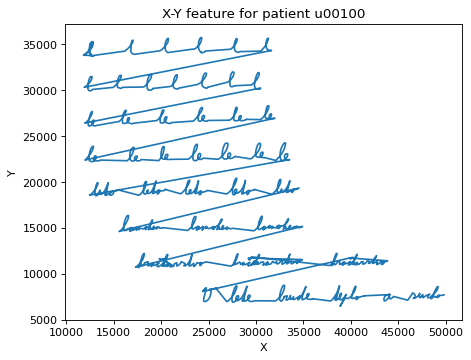

In [8]:
fig = plt.figure(dpi=80)
position_x = data_contact[patient_name][:, 0]
position_y = data_contact[patient_name][:, 1]
plt.plot(position_x, position_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y feature for patient {patient_name}')
plt.show()

#### Plot Pressure for Contact Data

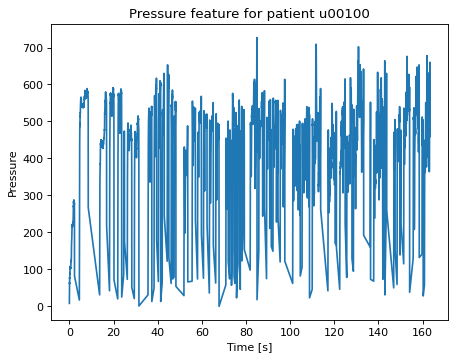

In [9]:
fig = plt.figure(dpi=80)
time = data_contact[patient_name][:, 2] - data_contact[patient_name][0, 2]  # Time in milliseconds
pressure = data_contact[patient_name][:, 6]
plt.plot(time * 1e-3, pressure)  # Convert time to seconds
plt.xlabel('Time [s]')
plt.ylabel('Pressure')
plt.title(f'Pressure feature for patient {patient_name}')
plt.show()

In [10]:
# Compute speeds (x, y, and total) for all users
speed_dict_contact = {}
for user_name in user_names:
    time = data_contact[user_name][:, 2] - data_contact[user_name][0, 2]  # Relative time (ms)
    position_x, position_y = data_contact[user_name][:, 0], data_contact[user_name][:, 1]
    speed_x, speed_y, speed = [0], [0], [0]  # Initialize speeds with zero

    for i in range(1, len(position_x)):
        delta_t = max((time[i] - time[i - 1]) * 1e-3, 1e-6)  # Ensure no division by zero
        vx = np.clip((position_x[i] - position_x[i - 1]) * 1e-3 / delta_t, 0.0, 10.0)
        vy = np.clip((position_y[i] - position_y[i - 1]) * 1e-3 / delta_t, 0.0, 10.0)
        speed_x.append(vx)
        speed_y.append(vy)
        speed.append((vx**2 + vy**2)**0.5)  # Total speed

    speed_dict_contact[user_name] = {"speed_x": speed_x, "speed_y": speed_y, "speed": speed}

### Generate and Save Visualizations

This cell creates visualizations of velocities (vx, vy, v) for each user. Each plot:

1. Uses a LineCollection for smooth colored segments based on speed.
2. Saves the visualizations as PNG files (xy_vx, xy_vy, xy_v) for further analysis or sharing.
3. Includes color bars and labeled axes for better interpretability.

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

# Normalize colormap for speed range
norm = Normalize(vmin=0, vmax=10)

# Create plots for speed_x, speed_y, and total speed
os.makedirs('../data/generated_colored_images/contact', exist_ok=True)

for user_name in user_names:
    position_x, position_y = data_contact[user_name][:, 0], data_contact[user_name][:, 1]
    speed_x = speed_dict_contact[user_name]["speed_x"]
    speed_y = speed_dict_contact[user_name]["speed_y"]
    speed = speed_dict_contact[user_name]["speed"]

    # Generate segments for line collections
    segments = [[(position_x[i], position_y[i]), (position_x[i + 1], position_y[i + 1])] for i in range(len(position_x) - 1)]

    # Function to create and save plots
    def create_plot(data, title, label, filename):
        fig, ax = plt.subplots()
        lc = LineCollection(segments, cmap='jet', norm=norm)
        lc.set_array(data)
        lc.set_linewidth(1.5)
        ax.add_collection(lc)
        ax.autoscale()
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.set_title(title)
        plt.colorbar(lc, label=label)
        plt.savefig(filename)
        plt.close(fig)

    # create_plot(speed_x, 'Velocity X (vx)', 'Vx', f'../data/generated_colored_images/contact/xy_vx_{user_name}.png')
    # create_plot(speed_y, 'Velocity Y (vy)', 'Vy', f'../data/generated_colored_images/contact/xy_vy_{user_name}.png')
    create_plot(speed, 'Velocity (v)', 'V', f'../data/generated_colored_images/contact/xy_v_{user_name}.png')

## **7. Data for Air Only**
Similarly, we extract data points where there is no contact (data_dict[:, 3] == 0) and store them in `data_on_air`.


In [12]:
data_on_air = {}

for patient in data_dict:
    # Count the number of air data points (where index 3 equals 0)
    nb_of_data_on_air = int(np.count_nonzero(data_dict[patient][:, 3] == 0))  
    data_on_air[patient] = np.zeros([nb_of_data_on_air, nb_of_features])  # Initialize empty array for air data
    
    # Fill the `data_on_air` with the air data
    k = 0
    for i in range(len(data_dict[patient])):
        if data_dict[patient][i, 3] == 0:  # Check if it's air data
            data_on_air[patient][k, :] = data_dict[patient][i, :]
            k += 1

#### Plot X-Y Positions for Air Data

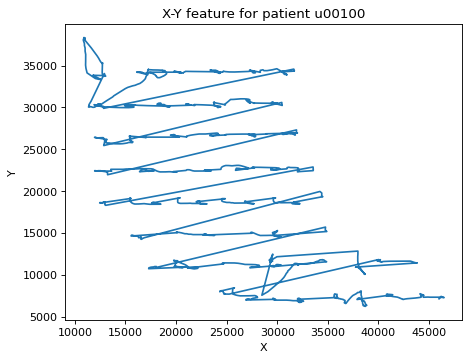

In [13]:
fig = plt.figure(dpi=80)
position_x = data_on_air[patient_name][:, 0]
position_y = data_on_air[patient_name][:, 1]
plt.plot(position_x, position_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y feature for patient {patient_name}')
plt.show()

#### Plot Pressure for Air Data

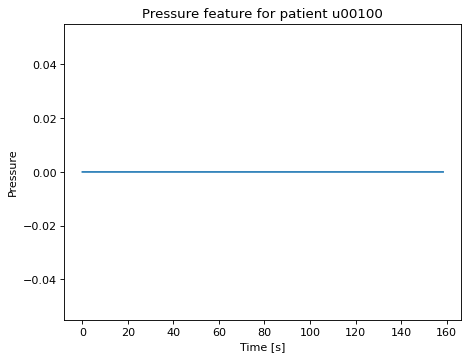

In [14]:
fig = plt.figure(dpi=80)
time = data_on_air[patient_name][:, 2] - data_on_air[patient_name][0, 2]  # Time in milliseconds
pressure = data_on_air[patient_name][:, 6]
plt.plot(time * 1e-3, pressure)  # Convert time to seconds
plt.xlabel('Time [s]')
plt.ylabel('Pressure')
plt.title(f'Pressure feature for patient {patient_name}')
plt.show()

In [15]:
# Compute speeds (x, y, and total) for all users
speed_dict_on_air = {}
for user_name in user_names:
    time = data_on_air[user_name][:, 2] - data_on_air[user_name][0, 2]  # Relative time (ms)
    position_x, position_y = data_on_air[user_name][:, 0], data_on_air[user_name][:, 1]
    speed_x, speed_y, speed = [0], [0], [0]  # Initialize speeds with zero

    for i in range(1, len(position_x)):
        delta_t = max((time[i] - time[i - 1]) * 1e-3, 1e-6)  # Ensure no division by zero
        vx = np.clip((position_x[i] - position_x[i - 1]) * 1e-3 / delta_t, 0.0, 10.0)
        vy = np.clip((position_y[i] - position_y[i - 1]) * 1e-3 / delta_t, 0.0, 10.0)
        speed_x.append(vx)
        speed_y.append(vy)
        speed.append((vx**2 + vy**2)**0.5)  # Total speed

    speed_dict_on_air[user_name] = {"speed_x": speed_x, "speed_y": speed_y, "speed": speed}

### Generate and Save Visualizations

This cell creates visualizations of velocities (vx, vy, v) for each user. Each plot:

1. Uses a LineCollection for smooth colored segments based on speed.
2. Saves the visualizations as PNG files (xy_vx, xy_vy, xy_v) for further analysis or sharing.
3. Includes color bars and labeled axes for better interpretability.

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

# Normalize colormap for speed range
norm = Normalize(vmin=0, vmax=10)

# Create plots for speed_x, speed_y, and total speed
os.makedirs('../data/generated_colored_images/on_air', exist_ok=True)

for user_name in user_names:
    position_x, position_y = data_on_air[user_name][:, 0], data_on_air[user_name][:, 1]
    speed_x = speed_dict_on_air[user_name]["speed_x"]
    speed_y = speed_dict_on_air[user_name]["speed_y"]
    speed = speed_dict_on_air[user_name]["speed"]

    # Generate segments for line collections
    segments = [[(position_x[i], position_y[i]), (position_x[i + 1], position_y[i + 1])] for i in range(len(position_x) - 1)]

    # Function to create and save plots
    def create_plot(data, title, label, filename):
        fig, ax = plt.subplots()
        lc = LineCollection(segments, cmap='jet', norm=norm)
        lc.set_array(data)
        lc.set_linewidth(1.5)
        ax.add_collection(lc)
        ax.autoscale()
        # plt.colorbar(lc, label=label)
        plt.savefig(filename)
        plt.close(fig)

    # create_plot(speed_x, 'Velocity X (vx)', 'Vx', f'../data/generated_colored_images/on_air/xy_vx_{user_name}.png')
    # create_plot(speed_y, 'Velocity Y (vy)', 'Vy', f'../data/generated_colored_images/on_air/xy_vy_{user_name}.png')
    create_plot(speed, 'Velocity (v)', 'V', f'../data/generated_colored_images/on_air/xy_v_{user_name}.png')